In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
res_prefix = 'mcmc_teste' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [4]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [38]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e25]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1 = 3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc, Tex =te, delv = dv[0], Xconv=1.e-7))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc, Tex = te, delv = dv[1], Xconv=1.e-7))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=1.e-7, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=1.e-7, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt((0.1*tb7)**2 + 1.08**2), 
                yerr = np.sqrt((0.1*tb6)**2 + 0.49**2),  
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    #ax.set_ylim(0,20)
    #ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    Tb_6_pred, Tb_6_err = Tb_6_pred[4], 

    return fig, ax, Tb_6_pred, Tb_7_pred

#### Generate the Data

In [31]:
np.random.seed(41)
lg_N = np.random.uniform(20, 24, 15)
Texe = np.random.uniform(10, 40, 15)

# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')


Tb7 = []
Tb6 = []

for lg_n,texe in zip(lg_N,Texe):

    Tb7.append(lte_model.get_intensity(line = 'c18o', Ju = 3, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=1.e-7))
    Tb6.append(lte_model.get_intensity(line = 'c18o', Ju = 2, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=1.e-7))

In [32]:
print(Tb7)

[1.2072936353106989, 0.41171169140756897, 12.547319158633863, 0.4025117566142987, 0.7091511943995266, 20.276071727790352, 1.5281231556131416, 15.605574852531726, 14.811987586369066, 6.3196712736505845, 4.621215164882261, 2.953335616492246, 1.435997476758133, 2.2825835570954145, 14.965302076288593]


#### T estimation loop(fix v)

In [33]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for i = 0 , Tb7 = 1.2, Tb6 = 1.9


100%|██████████| 10000/10000 [00:21<00:00, 468.22it/s]


dtauv_dT =  7.603524220414879e-05
dtauv_dT =  4.8490547853417165e-05
Tb7_dIv_dN = 1.45e-14, Tb6_dIv_dN = 1.81e-14
Tb7_dIv_dT = 0.19, Tb6_dIv_dT = 0.20
Ncols and lgNcols up 1.89e+23, lgNc = 2.33e+01
Ncols and lgNcols med 1.06e+21, lgNc = 2.10e+01
Ncols and lgNcols dwn 6.11e+20, lgNc = 2.08e+01
del T -> + 27.81, - 9.01
del N -> + 1.88e+23, - 4.45e+20
[[  1.81055115 273.80791264]]
[[  2.01302081 340.13157654]]
estimating for i = 1 , Tb7 = 0.4, Tb6 = 0.3


 74%|███████▎  | 7353/10000 [00:15<00:05, 467.80it/s]


KeyboardInterrupt: 

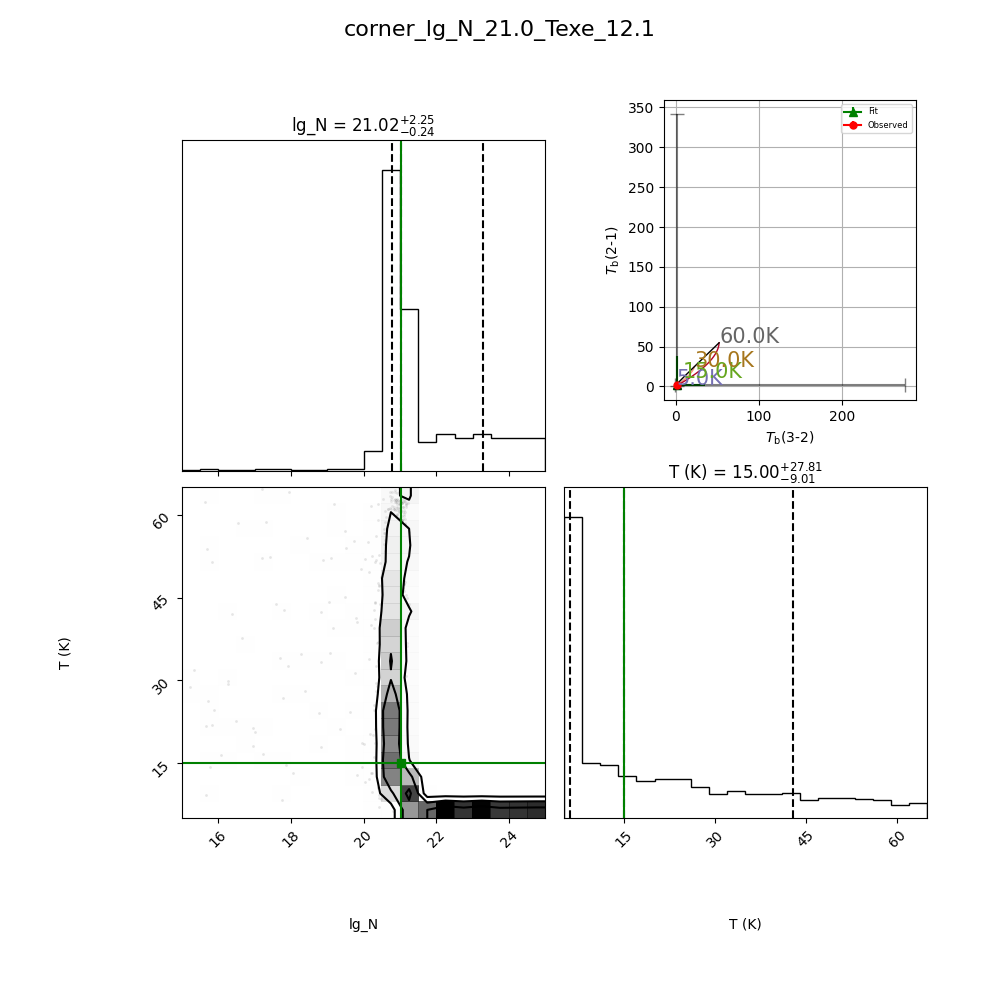

In [39]:
Texe_predicted = []
Texe_upq_predicted = []
Texe_lq_predicted = []

Ncol_predicted = []
Ncol_upq_predicted = []
Ncol_lq_predicted = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "mcmc_estimator_test"

ctr = 0

for i, (tb7, tb6) in enumerate(zip(Tb7, Tb6)):

    print(f"estimating for i = {i} , Tb7 = {tb7:.1f}, Tb6 = {tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = tb7, t2=tb6, 
                                                    s1=np.sqrt((0.1*tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(i,3)), str(round(i,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_predicted.append(T_qtls[0])
    Texe_predicted.append(T_qtls[1])
    Texe_upq_predicted.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_predicted.append(Ncol_qtls[0])
    Ncol_predicted.append(Ncol_qtls[1])
    Ncol_upq_predicted.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_7_predictions, Tb_6_predictions = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=tb7, tb6=tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_lg_N_'+str(round(lg_N[i],2))+'_Texe_'+str(round(Texe[i],1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(i,2))+'_v_'+str(round(i,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [35]:
# Calculate errorbars

T_err_predicted = [np.array(Texe_predicted)-np.array(Texe_lq_predicted),np.array(Texe_upq_predicted)-np.array(Texe_predicted)] #[tl,tu] for tl,tu in zip(

N_err_predicted = [np.array(Ncol_predicted)-np.array(Ncol_lq_predicted), np.array(Ncol_upq_predicted)-np.array(Ncol_predicted)]

print(np.shape(T_err_predicted))

(2, 15)


#### Visualize results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


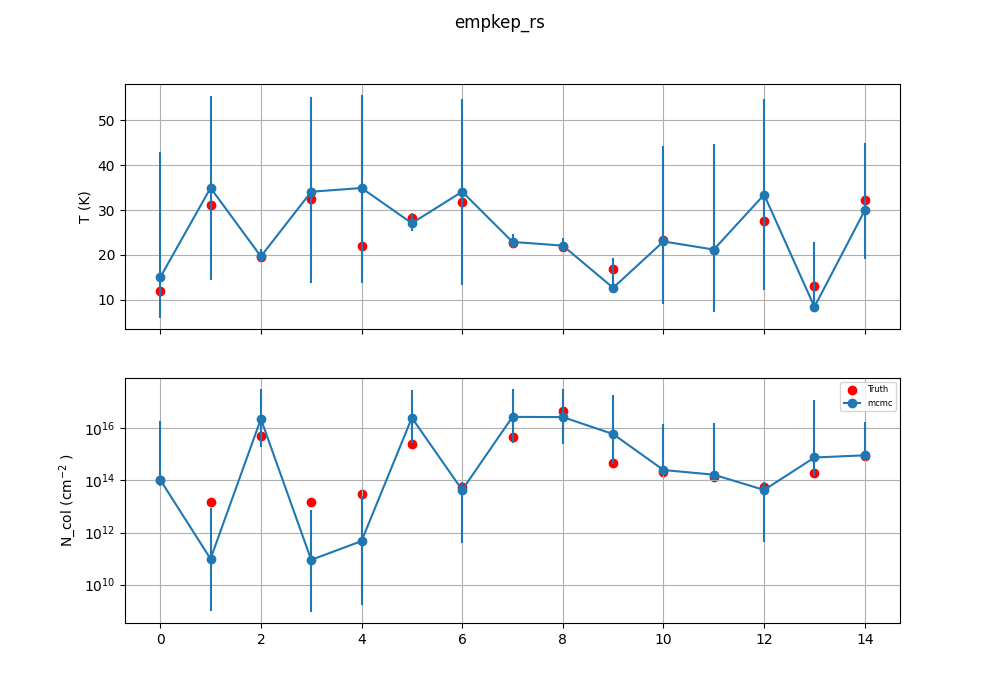

In [36]:
vis_results_fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

r = np.arange(len(Texe_predicted))
axes[0].errorbar(r, Texe_predicted, yerr=np.array(T_err_predicted), marker='o', label = 'mcmc')
axes[0].scatter(r, Texe, marker='o',  color = 'r', label = 'Truth')
#axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})



axes[1].errorbar(r, np.array(Ncol_predicted)*N_conv_fraction, yerr=np.array(N_err_predicted)*N_conv_fraction, marker='o', label = 'mcmc')
axes[1].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Truth')

axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
# axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

axes[2].errorbar(r, np.array(Tb7), yerr= np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), marker='o', label = 'mcmc')
axes[2].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Truth')

axes[2].set_ylabel(r"N_col (cm$^{-2}$ )")
# axes[1].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True)
axes[2].legend(prop={'size': 6})


vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')